## Autoencoder feature analysis
In this notebook we extract features from the original dataset and analyse the feature distributions. <br>
Samples are represented as an array of tipe:<br>
$x_0,\,y_0,\,z_0,\,x_1,\,y_1,\,z_1,\,...,\,x_n,\,y_n\,z_n,\, 0,\,0\,...\,0$ <br>
Where n is the number of hits in the track, and zero-padding is applied to match the same array dimension for every track in the dataset.

In [127]:
import yaml
from quake.utils.utils import load_runcard, save_runcard
from quake.models.autoencoder.autoencoder_dataloading import read_data
from quake.models.autoencoder.train import load_and_compile_network
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from quake.models.qsvm.qsvm_tester import get_features

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA, TruncatedSVD

In [128]:
# Loading the dataset
data_folder = Path("../../output_2/data")
train_folder = Path("../../output_2/models/autoencoder")
setup = load_runcard("../../output_2/cards/runcard.yaml")
setup["run_tf_eagerly"] = False
setup["seed"] = 42
train_generator, val_generator, test_generator = read_data(
    data_folder, train_folder, setup, split_from_maps=True
)
msetup = setup["model"]["autoencoder"]
max_input_nb = np.max(
    [
        train_generator.fixed_length_inputs.shape[1],
        val_generator.fixed_length_inputs.shape[1],
        test_generator.fixed_length_inputs.shape[1],
    ]
)
print(f"Arrays are padded to match dimension {max_input_nb}")

[INFO] (quake.autoencoder) Loading splitting maps from folder: ../../output_2/models/autoencoder
INFO:quake.autoencoder:Loading splitting maps from folder: ../../output_2/models/autoencoder
[INFO] (quake.autoencoder) Train dataset balancing: 125517 training points, of which 50.12% positives
INFO:quake.autoencoder:Train dataset balancing: 125517 training points, of which 50.12% positives
[INFO] (quake.autoencoder) Validation dataset balancing: 26897 training points, of which 49.77% positives
INFO:quake.autoencoder:Validation dataset balancing: 26897 training points, of which 49.77% positives
[INFO] (quake.autoencoder) Test dataset balancing: 26897 training points, of which 49.74% positives
INFO:quake.autoencoder:Test dataset balancing: 26897 training points, of which 49.74% positives


Arrays are padded to match dimension 76


In [129]:
msetup.update({"ckpt": train_folder.parent / f"autoencoder/autoencoder.h5"})

# Loading the network
network = load_and_compile_network(msetup, setup["run_tf_eagerly"], max_input_nb)

[INFO] (quake.autoencoder) Loading weights at ../../output_2/models/autoencoder/autoencoder.h5
INFO:quake.autoencoder:Loading weights at ../../output_2/models/autoencoder/autoencoder.h5


In [130]:
network.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Enc0 (LBAD)                 multiple                  15400     
                                                                 
 Enc1 (LBAD)                 multiple                  120600    
                                                                 
 Enc2 (LBAD)                 multiple                  150250    
                                                                 
 Enc3 (LBAD)                 multiple                  25100     
                                                                 
 Enc4 (LBAD)                 multiple                  1818      
                                                                 
 Dec0 (LBAD)                 multiple                  1900      
                                                                 
 Dec1 (LBAD)                 multiple                  

In [131]:
# Computing autoencoder predictions
validation_preds = network.predict(val_generator)

# Computing autoencoder performance (MSE metric)
network.evaluate(val_generator)

269/269 [==============================] - 1s 2ms/step - loss: 0.0160 - MSE: 0.0160


[0.01598246954381466, 0.01598246954381466]

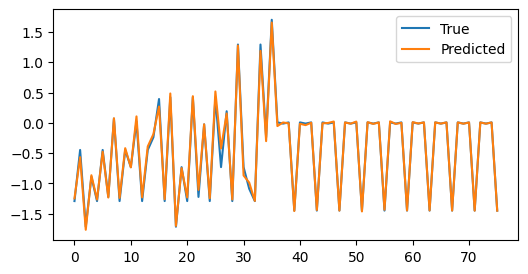

In [132]:
# Displaying the true value vs the autoencoder prediction
track_id = 1058
plt.figure(figsize=(6, 3))
plt.plot(val_generator.inputs[track_id])
plt.plot(validation_preds[track_id])
plt.legend(["True", "Predicted"])

In [133]:
# Loading features from the autoencoder latent space
# dataset and labels are lists. To get training, validation and test data, call entry 0, 1 and 2 respectively
dataset, labels = get_features(data_folder.parent, "autoencoder", setup)
latent_dim = dataset[0].shape[1]

print(f"Latent space dimension: {latent_dim}")

[INFO] (quake.autoencoder) Loading splitting maps from folder: ../../output_2/models/autoencoder
INFO:quake.autoencoder:Loading splitting maps from folder: ../../output_2/models/autoencoder
[INFO] (quake.autoencoder) Train dataset balancing: 125517 training points, of which 50.12% positives
INFO:quake.autoencoder:Train dataset balancing: 125517 training points, of which 50.12% positives
[INFO] (quake.autoencoder) Validation dataset balancing: 26897 training points, of which 49.77% positives
INFO:quake.autoencoder:Validation dataset balancing: 26897 training points, of which 49.77% positives
[INFO] (quake.autoencoder) Test dataset balancing: 26897 training points, of which 49.74% positives
INFO:quake.autoencoder:Test dataset balancing: 26897 training points, of which 49.74% positives
[INFO] (quake.autoencoder) Loading weights at ../../output_2/models/autoencoder/autoencoder.h5
INFO:quake.autoencoder:Loading weights at ../../output_2/models/autoencoder/autoencoder.h5


269/269 [==============================] - 0s 1ms/step
Latent space dimension: 18


In [134]:
# Rescaling features from 0 to 1
scaler = MinMaxScaler((0, 1))
dataset_train = scaler.fit_transform(dataset[0])

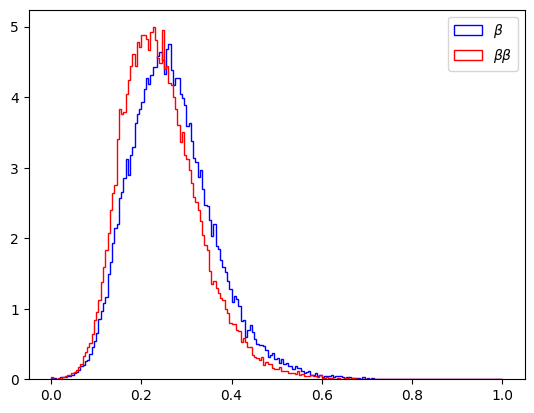

In [167]:
# Plotting feature distributions within classes
feature_nb = 0
plt.hist(
    dataset_train[labels[0] == 0, feature_nb],
    range=[0, 1],
    bins=200,
    histtype="step",
    density=True,
    color="blue",
)[-1]
plt.hist(
    dataset_train[labels[0] == 1, feature_nb],
    range=[0, 1],
    bins=200,
    histtype="step",
    density=True,
    color="red",
)[-1]
plt.legend([r"$\beta$", r"$\beta\beta$"])

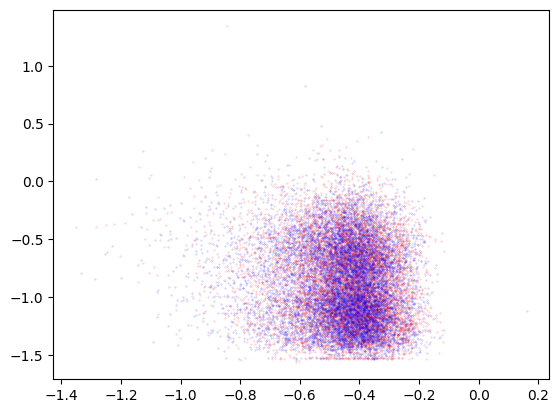

In [136]:
# 2D scatterplots
ft_1_idx = 3
ft_2_idx = 4
plt.scatter(
    x=dataset[0][labels[0] == 0, ft_1_idx][:10000],
    y=dataset[0][labels[0] == 0, ft_2_idx][:10000],
    s=0.1,
    alpha=0.3,
    c="r",
)
plt.scatter(
    x=dataset[0][labels[0] == 1, ft_1_idx][:10000],
    y=dataset[0][labels[0] == 1, ft_2_idx][:10000],
    s=0.1,
    alpha=0.3,
    c="b",
)

In [137]:
# Doing univariate analysis
label_relation = mutual_info_classif(dataset_train, labels[0])
print(label_relation)

[0.00853256 0.00117221 0.00612917 0.00101058 0.00234594 0.00182755
 0.02776239 0.00736423 0.0072688  0.         0.02902217 0.01319417
 0.0020044  0.00232257 0.         0.03113731 0.00505178 0.00540578]


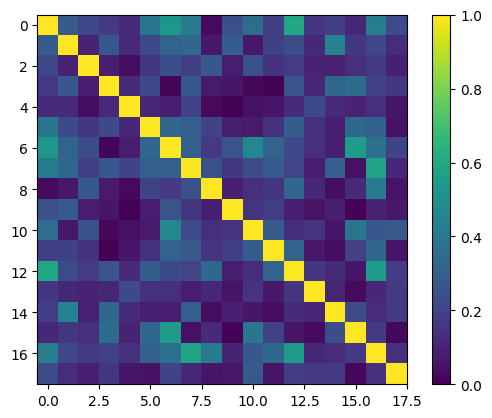

In [138]:
# Plotting linear correlations between features
corrmat = np.abs(np.corrcoef(dataset[0].T))
plt.imshow(corrmat, clim=[0.0, 1])
plt.colorbar()

In [139]:
# Preparing a subset for training an SVM
ds_train = scaler.transform(dataset[0])[:10000]  # dataset is already shuffled
ds_val = scaler.transform(dataset[1])[:10000]
ds_test = scaler.transform(dataset[2])[:10000]

In [140]:
# Training a gaussian SVM and optimizing hyperparameters
# With the settings below, it may take a few minutes to run.
param_grid = {
    "C": [0.1, 1, 10, 100, 1000, 10000],  # Regularization parameter
    "gamma": [0.001, 0.01, 0.1, 1, 10, 100],  # Kernel coefficient for 'rbf' kernel
}

gaussian = SVC(kernel="rbf")

grid_search = GridSearchCV(gaussian, param_grid, cv=3, n_jobs=-1, verbose=1)

grid_search.fit(ds_train, labels[0][:10000])


best_C = grid_search.best_params_["C"]
best_gamma = grid_search.best_params_["gamma"]
best_model = grid_search.best_estimator_

gaussian_clf = SVC(kernel="rbf", C=best_C, gamma=best_gamma).fit(
    ds_train, labels[0][:10000]
)
accuracy_gau = gaussian_clf.score(ds_val, labels[1][:10000])

print("Best gaussian model is", best_model, "with accuracy", accuracy_gau)

linear_clf = SVC(kernel="linear").fit(ds_train, labels[0][:10000])
accuracy_lin = linear_clf.score(ds_val, labels[1][:10000])
print("Best linear model is accuracy:", accuracy_lin)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best gaussian model is SVC(C=1000, gamma=0.1) with accuracy 0.6465
Best linear model is accuracy: 0.6465


In [141]:
# Doing PCA analysis
pca = PCA(n_components=latent_dim)
pca.fit(dataset_train)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.22354619 0.13786531 0.11519206 0.0702033  0.06431106 0.06013716
 0.04949781 0.04552901 0.04146523 0.03749594 0.03438162 0.03099725
 0.02506232 0.0205575  0.01646963 0.01445671 0.00751131 0.00532061]
[65.77146  51.651314 47.213387 36.858074 35.27741  34.113426 30.949017
 29.68233  28.326694 26.936798 25.7939   24.491503 22.02239  19.94523
 17.852365 16.725863 12.056236 10.14693 ]


Text(0, 0.5, 'Total explained variance')

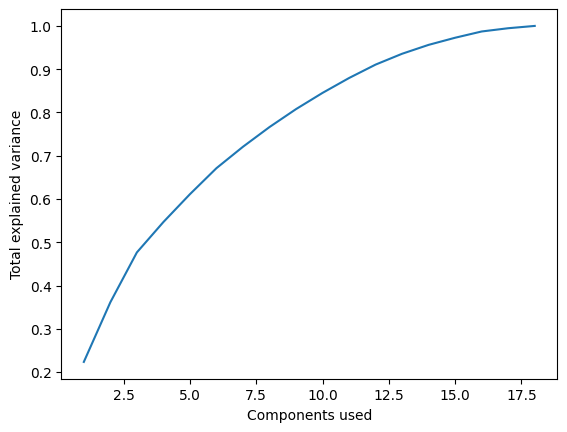

In [142]:
plt.plot(np.arange(1, latent_dim + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Components used")
plt.ylabel("Total explained variance")

In [143]:
# keeping only some components
nb_features_to_keep = 3
ds_train_transformed = pca.transform(ds_train)[:, :nb_features_to_keep]
ds_val_transformed = pca.transform(ds_val)[:, :nb_features_to_keep]

In [144]:
gaus = SVC(kernel="rbf", C=1000, gamma=0.1)
gaus.fit(ds_train_transformed, labels[0][:10000])
gaus.score(ds_val_transformed, labels[1][:10000])

0.6315